
.. redirect-from:: /tutorials/intermediate/constrainedlayout_guide


# Constrained layout guide

Use *constrained layout* to fit plots within your figure cleanly.

*Constrained layout* automatically adjusts subplots so that decorations like tick
labels, legends, and colorbars do not overlap, while still preserving the
logical layout requested by the user.

*Constrained layout* is similar to `Tight
layout<tight_layout_guide>`, but is substantially more
flexible.  It handles colorbars placed on multiple Axes
(`colorbar_placement`) nested layouts (`~.Figure.subfigures`) and Axes that
span rows or columns (`~.pyplot.subplot_mosaic`), striving to align spines from
Axes in the same row or column.  In addition, `Compressed layout
<compressed_layout>` will try and move fixed aspect-ratio Axes closer together.
These features are described in this document, as well as some
`implementation details <cl_notes_on_algorithm>` discussed at the end.

*Constrained layout* typically needs to be activated before any Axes are added to
a figure. Two ways of doing so are

* using the respective argument to `~.pyplot.subplots`,
  `~.pyplot.figure`, `~.pyplot.subplot_mosaic` e.g.::

      plt.subplots(layout="constrained")

* activate it via `rcParams<customizing-with-dynamic-rc-settings>`, like::

      plt.rcParams['figure.constrained_layout.use'] = True

Those are described in detail throughout the following sections.

<div class="alert alert-danger"><h4>Warning</h4><p>Calling `~.pyplot.tight_layout` will turn off *constrained layout*!</p></div>

## Simple example

With the default Axes positioning, the axes title, axis labels, or tick labels
can sometimes go outside the figure area, and thus get clipped.


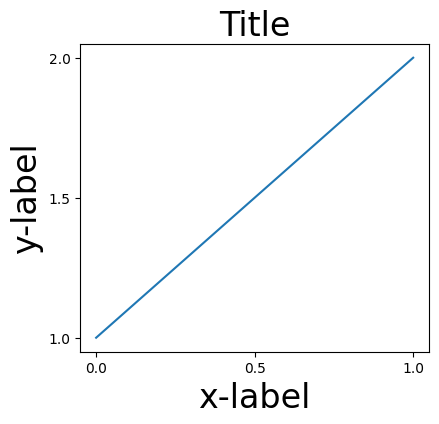

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

plt.rcParams['savefig.facecolor'] = "0.8"
plt.rcParams['figure.figsize'] = 4.5, 4.
plt.rcParams['figure.max_open_warning'] = 50


def example_plot(ax, fontsize=12, hide_labels=False):
    ax.plot([1, 2])

    ax.locator_params(nbins=3)
    if hide_labels:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    else:
        ax.set_xlabel('x-label', fontsize=fontsize)
        ax.set_ylabel('y-label', fontsize=fontsize)
        ax.set_title('Title', fontsize=fontsize)

fig, ax = plt.subplots(layout=None)
example_plot(ax, fontsize=24)

To prevent this, the location of Axes needs to be adjusted. For
subplots, this can be done manually by adjusting the subplot parameters
using `.Figure.subplots_adjust`. However, specifying your figure with the
``layout="constrained"`` keyword argument will do the adjusting
automatically.



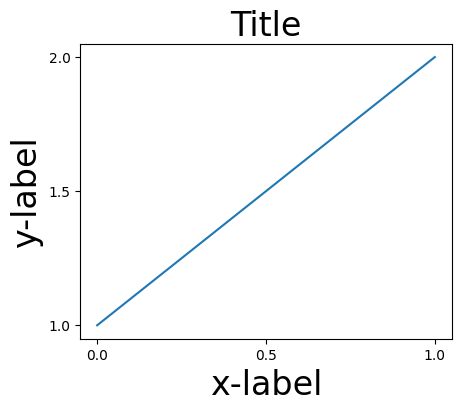

In [2]:
fig, ax = plt.subplots(layout="constrained")
example_plot(ax, fontsize=24)

When you have multiple subplots, often you see labels of different
Axes overlapping each other.



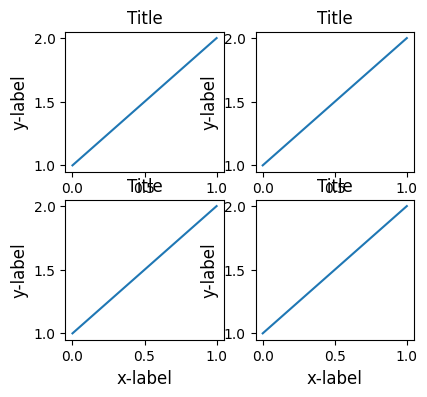

In [3]:
fig, axs = plt.subplots(2, 2, layout=None)
for ax in axs.flat:
    example_plot(ax)

Specifying ``layout="constrained"`` in the call to ``plt.subplots``
causes the layout to be properly constrained.



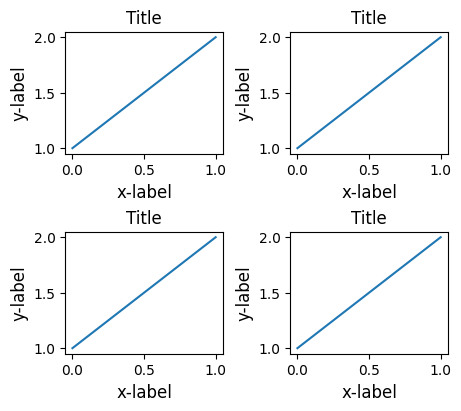

In [4]:
fig, axs = plt.subplots(2, 2, layout="constrained")
for ax in axs.flat:
    example_plot(ax)

## Colorbars

If you create a colorbar with `.Figure.colorbar`, you need to make room for
it.  *Constrained layout* does this automatically.  Note that if you
specify ``use_gridspec=True`` it will be ignored because this option is made
for improving the layout via ``tight_layout``.

<div class="alert alert-info"><h4>Note</h4><p>For the `~.axes.Axes.pcolormesh` keyword arguments (``pc_kwargs``) we use a
  dictionary to keep the calls consistent across this document.</p></div>



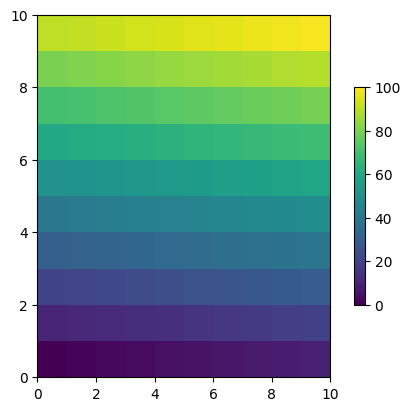

In [5]:
arr = np.arange(100).reshape((10, 10))
norm = mcolors.Normalize(vmin=0., vmax=100.)
# see note above: this makes all pcolormesh calls consistent:
pc_kwargs = {'rasterized': True, 'cmap': 'viridis', 'norm': norm}
fig, ax = plt.subplots(figsize=(4, 4), layout="constrained")
im = ax.pcolormesh(arr, **pc_kwargs)
fig.colorbar(im, ax=ax, shrink=0.6)

If you specify a list of Axes (or other iterable container) to the
``ax`` argument of ``colorbar``, *constrained layout* will take space from
the specified Axes.



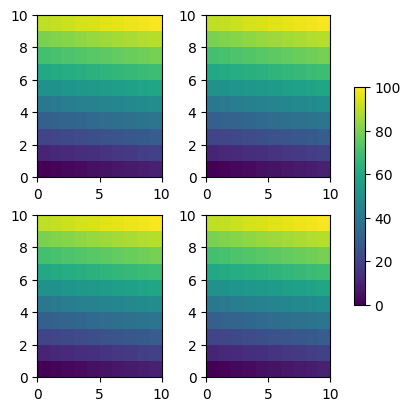

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(4, 4), layout="constrained")
for ax in axs.flat:
    im = ax.pcolormesh(arr, **pc_kwargs)
fig.colorbar(im, ax=axs, shrink=0.6)

If you specify a list of Axes from inside a grid of Axes, the colorbar
will steal space appropriately, and leave a gap, but all subplots will
still be the same size.



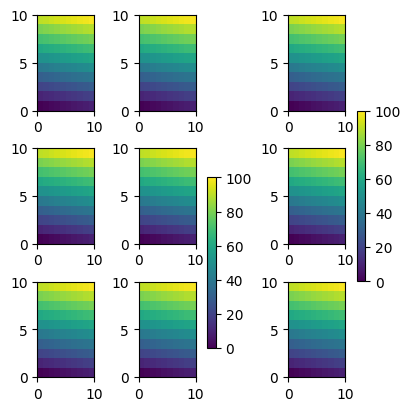

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(4, 4), layout="constrained")
for ax in axs.flat:
    im = ax.pcolormesh(arr, **pc_kwargs)
fig.colorbar(im, ax=axs[1:, 1], shrink=0.8)
fig.colorbar(im, ax=axs[:, -1], shrink=0.6)

## Suptitle

*Constrained layout* can also make room for `~.Figure.suptitle`.



Text(0.5, 0.98, 'Big Suptitle')

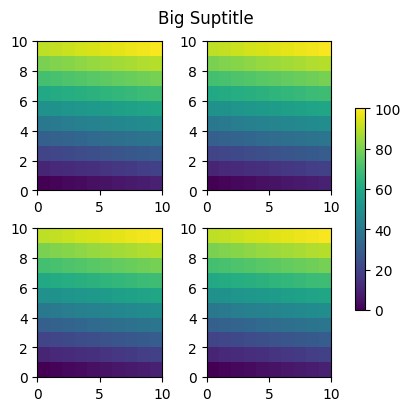

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(4, 4), layout="constrained")
for ax in axs.flat:
    im = ax.pcolormesh(arr, **pc_kwargs)
fig.colorbar(im, ax=axs, shrink=0.6)
fig.suptitle('Big Suptitle')

## Legends

Legends can be placed outside of their parent axis.
*Constrained layout* is designed to handle this for :meth:`.Axes.legend`.
However, *constrained layout* does *not* handle legends being created via
:meth:`.Figure.legend` (yet).



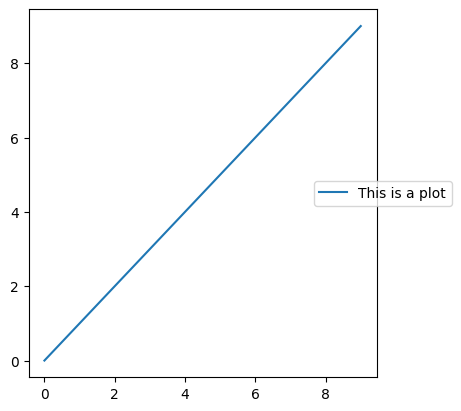

In [9]:
fig, ax = plt.subplots(layout="constrained")
ax.plot(np.arange(10), label='This is a plot')
ax.legend(loc='center left', bbox_to_anchor=(0.8, 0.5))

However, this will steal space from a subplot layout:



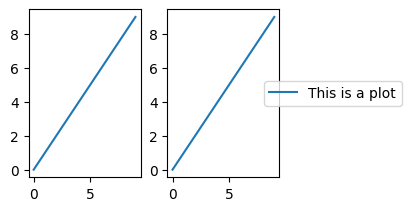

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2), layout="constrained")
axs[0].plot(np.arange(10))
axs[1].plot(np.arange(10), label='This is a plot')
axs[1].legend(loc='center left', bbox_to_anchor=(0.8, 0.5))

In order for a legend or other artist to *not* steal space
from the subplot layout, we can ``leg.set_in_layout(False)``.
Of course this can mean the legend ends up
cropped, but can be useful if the plot is subsequently called
with ``fig.savefig('outname.png', bbox_inches='tight')``.  Note,
however, that the legend's ``get_in_layout`` status will have to be
toggled again to make the saved file work, and we must manually
trigger a draw if we want *constrained layout* to adjust the size
of the Axes before printing.



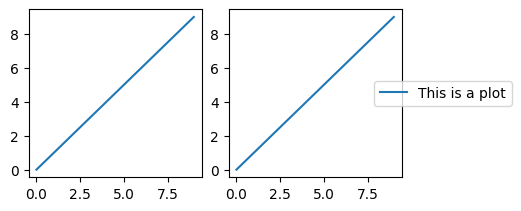

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2), layout="constrained")

axs[0].plot(np.arange(10))
axs[1].plot(np.arange(10), label='This is a plot')
leg = axs[1].legend(loc='center left', bbox_to_anchor=(0.8, 0.5))
leg.set_in_layout(False)
# trigger a draw so that constrained layout is executed once
# before we turn it off when printing....
fig.canvas.draw()
# we want the legend included in the bbox_inches='tight' calcs.
leg.set_in_layout(True)
# we don't want the layout to change at this point.
fig.set_layout_engine('none')
try:
    fig.savefig('../../../doc/_static/constrained_layout_1b.png',
                bbox_inches='tight', dpi=100)
except FileNotFoundError:
    # this allows the script to keep going if run interactively and
    # the directory above doesn't exist
    pass

The saved file looks like:

<img src="file://_static/constrained_layout_1b.png" align="center">

A better way to get around this awkwardness is to simply
use the legend method provided by `.Figure.legend`:



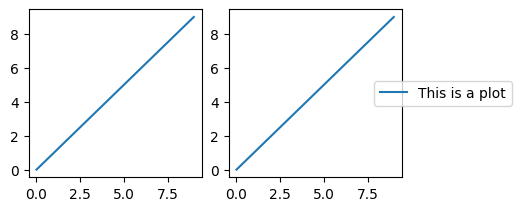

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2), layout="constrained")
axs[0].plot(np.arange(10))
lines = axs[1].plot(np.arange(10), label='This is a plot')
labels = [l.get_label() for l in lines]
leg = fig.legend(lines, labels, loc='center left',
                 bbox_to_anchor=(0.8, 0.5), bbox_transform=axs[1].transAxes)
try:
    fig.savefig('../../../doc/_static/constrained_layout_2b.png',
                bbox_inches='tight', dpi=100)
except FileNotFoundError:
    # this allows the script to keep going if run interactively and
    # the directory above doesn't exist
    pass

The saved file looks like:

<img src="file://_static/constrained_layout_2b.png" align="center">




## Padding and spacing

Padding between Axes is controlled in the horizontal by *w_pad* and
*wspace*, and vertical by *h_pad* and *hspace*.  These can be edited
via `~.layout_engine.ConstrainedLayoutEngine.set`.  *w/h_pad* are
the minimum space around the Axes in units of inches:



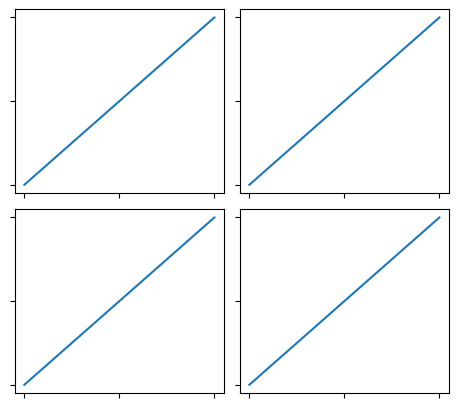

In [13]:
fig, axs = plt.subplots(2, 2, layout="constrained")
for ax in axs.flat:
    example_plot(ax, hide_labels=True)
fig.get_layout_engine().set(w_pad=4 / 72, h_pad=4 / 72, hspace=0,
                            wspace=0)

Spacing between subplots is further set by *wspace* and *hspace*. These
are specified as a fraction of the size of the subplot group as a whole.
If these values are smaller than *w_pad* or *h_pad*, then the fixed pads are
used instead. Note in the below how the space at the edges doesn't change
from the above, but the space between subplots does.



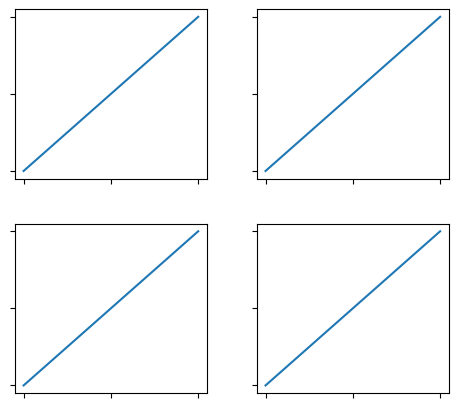

In [14]:
fig, axs = plt.subplots(2, 2, layout="constrained")
for ax in axs.flat:
    example_plot(ax, hide_labels=True)
fig.get_layout_engine().set(w_pad=4 / 72, h_pad=4 / 72, hspace=0.2,
                            wspace=0.2)

If there are more than two columns, the *wspace* is shared between them,
so here the wspace is divided in two, with a *wspace* of 0.1 between each
column:



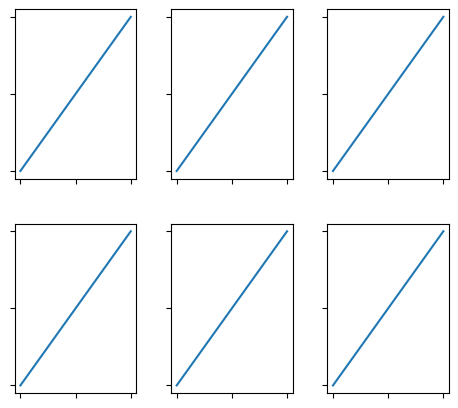

In [15]:
fig, axs = plt.subplots(2, 3, layout="constrained")
for ax in axs.flat:
    example_plot(ax, hide_labels=True)
fig.get_layout_engine().set(w_pad=4 / 72, h_pad=4 / 72, hspace=0.2,
                            wspace=0.2)

GridSpecs also have optional *hspace* and *wspace* keyword arguments,
that will be used instead of the pads set by *constrained layout*:



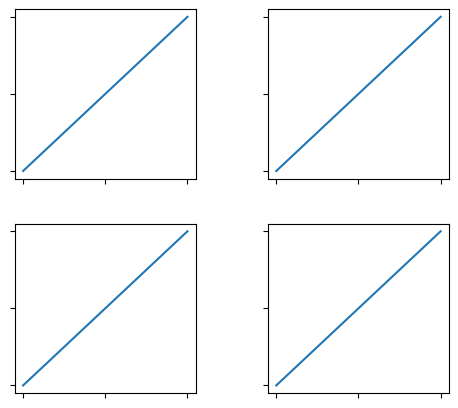

In [16]:
fig, axs = plt.subplots(2, 2, layout="constrained",
                        gridspec_kw={'wspace': 0.3, 'hspace': 0.2})
for ax in axs.flat:
    example_plot(ax, hide_labels=True)
# this has no effect because the space set in the gridspec trumps the
# space set in *constrained layout*.
fig.get_layout_engine().set(w_pad=4 / 72, h_pad=4 / 72, hspace=0.0,
                            wspace=0.0)

### Spacing with colorbars

Colorbars are placed a distance *pad* from their parent, where *pad*
is a fraction of the width of the parent(s).  The spacing to the
next subplot is then given by *w/hspace*.



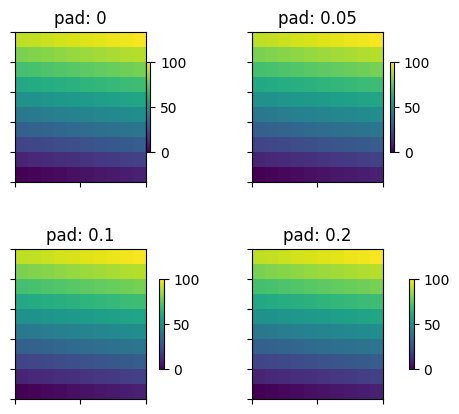

In [17]:
fig, axs = plt.subplots(2, 2, layout="constrained")
pads = [0, 0.05, 0.1, 0.2]
for pad, ax in zip(pads, axs.flat):
    pc = ax.pcolormesh(arr, **pc_kwargs)
    fig.colorbar(pc, ax=ax, shrink=0.6, pad=pad)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(f'pad: {pad}')
fig.get_layout_engine().set(w_pad=2 / 72, h_pad=2 / 72, hspace=0.2,
                            wspace=0.2)

## rcParams

There are five `rcParams<customizing-with-dynamic-rc-settings>`
that can be set, either in a script or in the :file:`matplotlibrc`
file. They all have the prefix ``figure.constrained_layout``:

- *use*: Whether to use *constrained layout*. Default is False
- *w_pad*, *h_pad*:    Padding around Axes objects.
  Float representing inches.  Default is 3./72. inches (3 pts)
- *wspace*, *hspace*:  Space between subplot groups.
  Float representing a fraction of the subplot widths being separated.
  Default is 0.02.



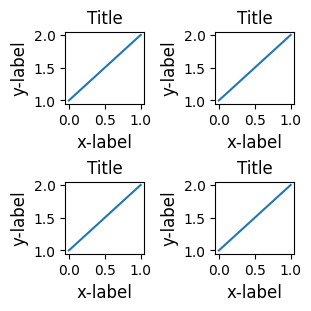

In [18]:
plt.rcParams['figure.constrained_layout.use'] = True
fig, axs = plt.subplots(2, 2, figsize=(3, 3))
for ax in axs.flat:
    example_plot(ax)

## Use with GridSpec

*Constrained layout* is meant to be used
with :func:`~matplotlib.figure.Figure.subplots`,
:func:`~matplotlib.figure.Figure.subplot_mosaic`, or
:func:`~matplotlib.gridspec.GridSpec` with
:func:`~matplotlib.figure.Figure.add_subplot`.

Note that in what follows ``layout="constrained"``



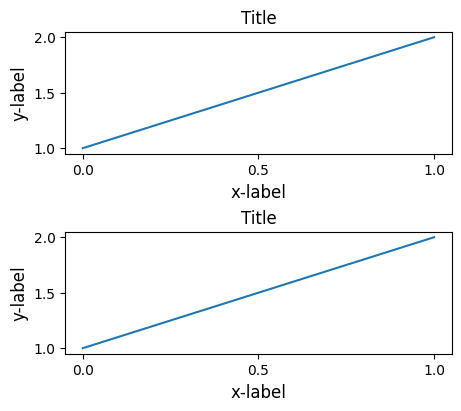

In [19]:
plt.rcParams['figure.constrained_layout.use'] = False
fig = plt.figure(layout="constrained")

gs1 = gridspec.GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])

example_plot(ax1)
example_plot(ax2)

More complicated gridspec layouts are possible.  Note here we use the
convenience functions `~.Figure.add_gridspec` and
`~.SubplotSpec.subgridspec`.



Text(0.5, 0, 'x-label')

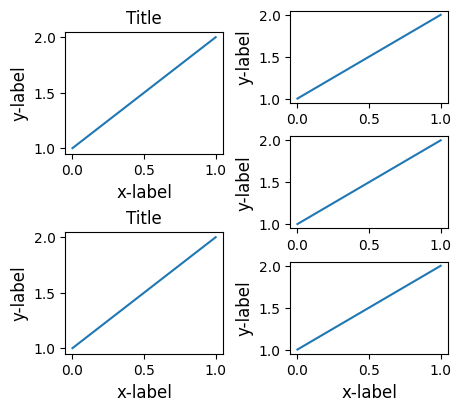

In [20]:
fig = plt.figure(layout="constrained")

gs0 = fig.add_gridspec(1, 2)

gs1 = gs0[0].subgridspec(2, 1)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])

example_plot(ax1)
example_plot(ax2)

gs2 = gs0[1].subgridspec(3, 1)

for ss in gs2:
    ax = fig.add_subplot(ss)
    example_plot(ax)
    ax.set_title("")
    ax.set_xlabel("")

ax.set_xlabel("x-label", fontsize=12)

Note that in the above the left and right columns don't have the same
vertical extent.  If we want the top and bottom of the two grids to line up
then they need to be in the same gridspec.  We need to make this figure
larger as well in order for the Axes not to collapse to zero height:



Text(0.5, 0.98, 'Overlapping Gridspecs')

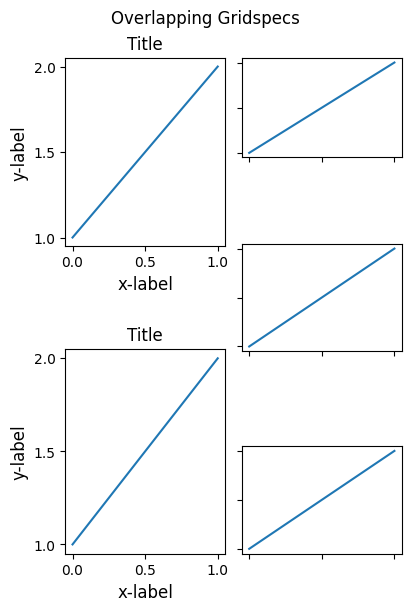

In [21]:
fig = plt.figure(figsize=(4, 6), layout="constrained")

gs0 = fig.add_gridspec(6, 2)

ax1 = fig.add_subplot(gs0[:3, 0])
ax2 = fig.add_subplot(gs0[3:, 0])

example_plot(ax1)
example_plot(ax2)

ax = fig.add_subplot(gs0[0:2, 1])
example_plot(ax, hide_labels=True)
ax = fig.add_subplot(gs0[2:4, 1])
example_plot(ax, hide_labels=True)
ax = fig.add_subplot(gs0[4:, 1])
example_plot(ax, hide_labels=True)
fig.suptitle('Overlapping Gridspecs')

This example uses two gridspecs to have the colorbar only pertain to
one set of pcolors.  Note how the left column is wider than the
two right-hand columns because of this.  Of course, if you wanted the
subplots to be the same size you only needed one gridspec.  Note that
the same effect can be achieved using `~.Figure.subfigures`.



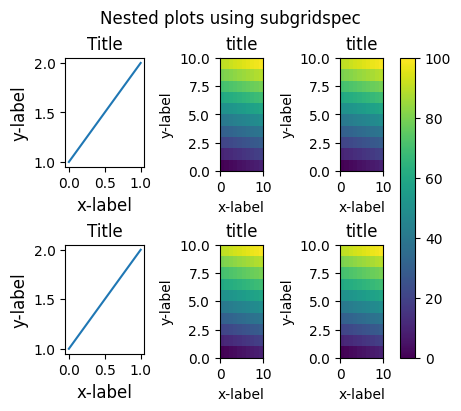

In [22]:
fig = plt.figure(layout="constrained")
gs0 = fig.add_gridspec(1, 2, figure=fig, width_ratios=[1, 2])
gs_left = gs0[0].subgridspec(2, 1)
gs_right = gs0[1].subgridspec(2, 2)

for gs in gs_left:
    ax = fig.add_subplot(gs)
    example_plot(ax)
axs = []
for gs in gs_right:
    ax = fig.add_subplot(gs)
    pcm = ax.pcolormesh(arr, **pc_kwargs)
    ax.set_xlabel('x-label')
    ax.set_ylabel('y-label')
    ax.set_title('title')
    axs += [ax]
fig.suptitle('Nested plots using subgridspec')
fig.colorbar(pcm, ax=axs)

Rather than using subgridspecs, Matplotlib now provides `~.Figure.subfigures`
which also work with *constrained layout*:



Text(0.5, 0.98, 'Nested plots using subfigures')

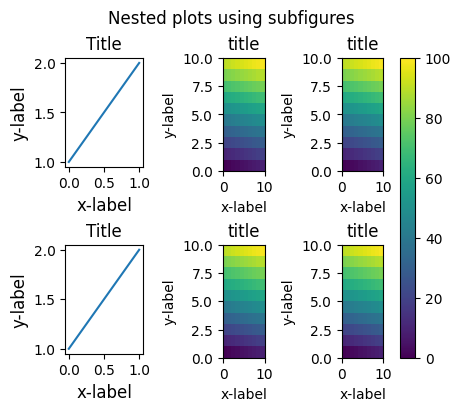

In [23]:
fig = plt.figure(layout="constrained")
sfigs = fig.subfigures(1, 2, width_ratios=[1, 2])

axs_left = sfigs[0].subplots(2, 1)
for ax in axs_left.flat:
    example_plot(ax)

axs_right = sfigs[1].subplots(2, 2)
for ax in axs_right.flat:
    pcm = ax.pcolormesh(arr, **pc_kwargs)
    ax.set_xlabel('x-label')
    ax.set_ylabel('y-label')
    ax.set_title('title')
fig.colorbar(pcm, ax=axs_right)
fig.suptitle('Nested plots using subfigures')

## Manually setting Axes positions

There can be good reasons to manually set an Axes position.  A manual call
to `~.axes.Axes.set_position` will set the Axes so *constrained layout* has
no effect on it anymore. (Note that *constrained layout* still leaves the
space for the Axes that is moved).



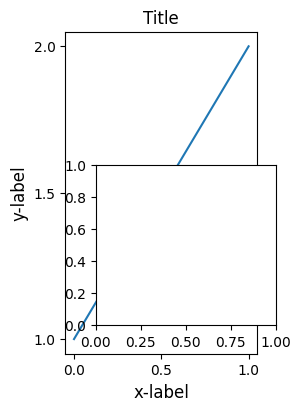

In [24]:
fig, axs = plt.subplots(1, 2, layout="constrained")
example_plot(axs[0], fontsize=12)
axs[1].set_position([0.2, 0.2, 0.4, 0.4])


## Grids of fixed aspect-ratio Axes: "compressed" layout

*Constrained layout* operates on the grid of "original" positions for
Axes. However, when Axes have fixed aspect ratios, one side is usually made
shorter, and leaves large gaps in the shortened direction. In the following,
the Axes are square, but the figure quite wide so there is a horizontal gap:



Text(0.5, 0.98, "fixed-aspect plots, layout='constrained'")

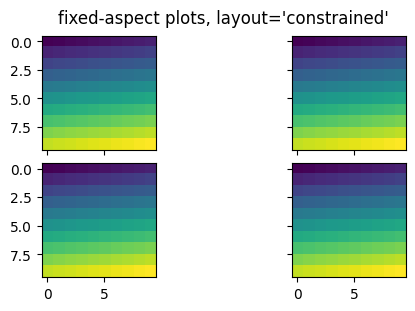

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(5, 3),
                        sharex=True, sharey=True, layout="constrained")
for ax in axs.flat:
    ax.imshow(arr)
fig.suptitle("fixed-aspect plots, layout='constrained'")

One obvious way of fixing this is to make the figure size more square,
however, closing the gaps exactly requires trial and error.  For simple grids
of Axes we can use ``layout="compressed"`` to do the job for us:



Text(0.5, 0.98, "fixed-aspect plots, layout='compressed'")

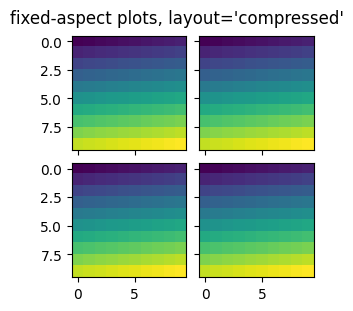

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(5, 3),
                        sharex=True, sharey=True, layout='compressed')
for ax in axs.flat:
    ax.imshow(arr)
fig.suptitle("fixed-aspect plots, layout='compressed'")

## Manually turning off *constrained layout*

*Constrained layout* usually adjusts the Axes positions on each draw
of the figure.  If you want to get the spacing provided by
*constrained layout* but not have it update, then do the initial
draw and then call ``fig.set_layout_engine('none')``.
This is potentially useful for animations where the tick labels may
change length.

Note that *constrained layout* is turned off for ``ZOOM`` and ``PAN``
GUI events for the backends that use the toolbar.  This prevents the
Axes from changing position during zooming and panning.


## Limitations

### Incompatible functions

*Constrained layout* will work with `.pyplot.subplot`, but only if the
number of rows and columns is the same for each call.
The reason is that each call to `.pyplot.subplot` will create a new
`.GridSpec` instance if the geometry is not the same, and
*constrained layout*.  So the following works fine:



Text(0.5, 0.98, 'Homogeneous nrows, ncols')

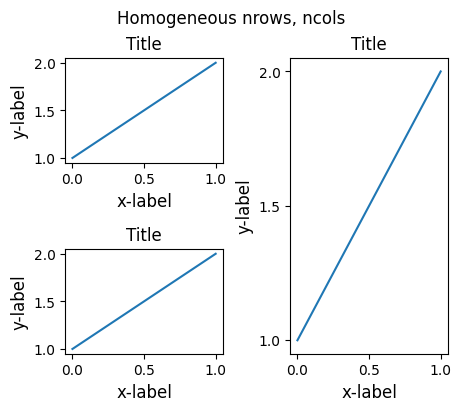

In [27]:
fig = plt.figure(layout="constrained")

ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 3)
# third Axes that spans both rows in second column:
ax3 = plt.subplot(2, 2, (2, 4))

example_plot(ax1)
example_plot(ax2)
example_plot(ax3)
plt.suptitle('Homogeneous nrows, ncols')

but the following leads to a poor layout:



Text(0.5, 0.98, 'Mixed nrows, ncols')

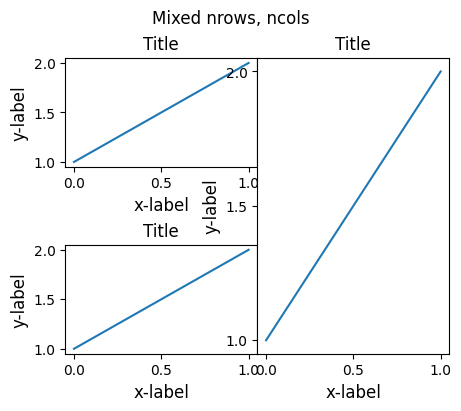

In [28]:
fig = plt.figure(layout="constrained")

ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 3)
ax3 = plt.subplot(1, 2, 2)

example_plot(ax1)
example_plot(ax2)
example_plot(ax3)
plt.suptitle('Mixed nrows, ncols')

Similarly,
`~matplotlib.pyplot.subplot2grid` works with the same limitation
that nrows and ncols cannot change for the layout to look good.



Text(0.5, 0.98, 'subplot2grid')

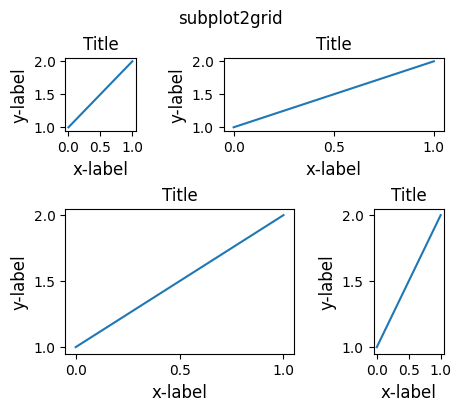

In [29]:
fig = plt.figure(layout="constrained")

ax1 = plt.subplot2grid((3, 3), (0, 0))
ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=2)
ax3 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
ax4 = plt.subplot2grid((3, 3), (1, 2), rowspan=2)

example_plot(ax1)
example_plot(ax2)
example_plot(ax3)
example_plot(ax4)
fig.suptitle('subplot2grid')

### Other caveats

* *Constrained layout* only considers ticklabels, axis labels, titles, and
  legends.  Thus, other artists may be clipped and also may overlap.

* It assumes that the extra space needed for ticklabels, axis labels,
  and titles is independent of original location of Axes. This is
  often true, but there are rare cases where it is not.

* There are small differences in how the backends handle rendering fonts,
  so the results will not be pixel-identical.

* An artist using Axes coordinates that extend beyond the Axes
  boundary will result in unusual layouts when added to an
  Axes. This can be avoided by adding the artist directly to the
  :class:`~matplotlib.figure.Figure` using
  :meth:`~matplotlib.figure.Figure.add_artist`. See
  :class:`~matplotlib.patches.ConnectionPatch` for an example.



## Debugging

*Constrained layout* can fail in somewhat unexpected ways.  Because it uses
a constraint solver the solver can find solutions that are mathematically
correct, but that aren't at all what the user wants.  The usual failure
mode is for all sizes to collapse to their smallest allowable value. If
this happens, it is for one of two reasons:

1. There was not enough room for the elements you were requesting to draw.
2. There is a bug - in which case open an issue at
   https://github.com/matplotlib/matplotlib/issues.

If there is a bug, please report with a self-contained example that does
not require outside data or dependencies (other than numpy).




## Notes on the algorithm

The algorithm for the constraint is relatively straightforward, but
has some complexity due to the complex ways we can lay out a figure.

Layout in Matplotlib is carried out with gridspecs
via the `.GridSpec` class. A gridspec is a logical division of the figure
into rows and columns, with the relative width of the Axes in those
rows and columns set by *width_ratios* and *height_ratios*.

In *constrained layout*, each gridspec gets a *layoutgrid* associated with
it.  The *layoutgrid* has a series of ``left`` and ``right`` variables
for each column, and ``bottom`` and ``top`` variables for each row, and
further it has a margin for each of left, right, bottom and top.  In each
row, the bottom/top margins are widened until all the decorators
in that row are accommodated.  Similarly, for columns and the left/right
margins.


### Simple case: one Axes

For a single Axes the layout is straight forward.  There is one parent
layoutgrid for the figure consisting of one column and row, and
a child layoutgrid for the gridspec that contains the Axes, again
consisting of one row and column. Space is made for the "decorations" on
each side of the Axes.  In the code, this is accomplished by the entries in
``do_constrained_layout()`` like::

    gridspec._layoutgrid[0, 0].edit_margin_min('left',
          -bbox.x0 + pos.x0 + w_pad)

where ``bbox`` is the tight bounding box of the Axes, and ``pos`` its
position.  Note how the four margins encompass the Axes decorations.



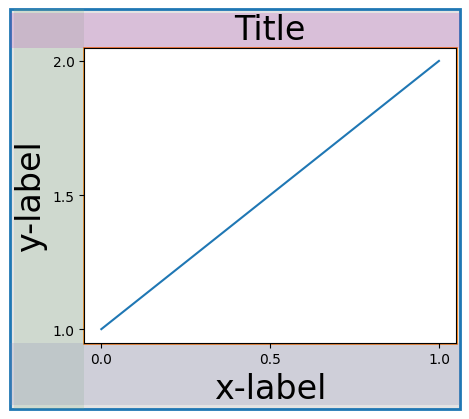

In [30]:
from matplotlib._layoutgrid import plot_children

fig, ax = plt.subplots(layout="constrained")
example_plot(ax, fontsize=24)
plot_children(fig)

### Simple case: two Axes
When there are multiple Axes they have their layouts bound in
simple ways.  In this example the left Axes has much larger decorations
than the right, but they share a bottom margin, which is made large
enough to accommodate the larger xlabel.   Same with the shared top
margin.  The left and right margins are not shared, and hence are
allowed to be different.



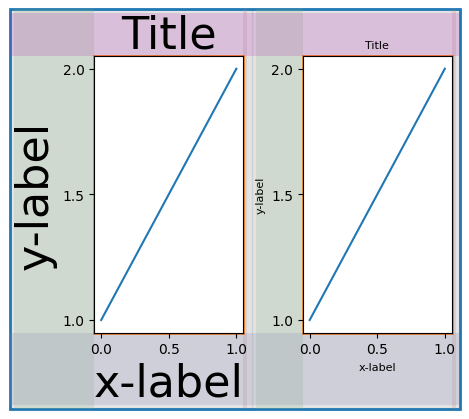

In [31]:
fig, ax = plt.subplots(1, 2, layout="constrained")
example_plot(ax[0], fontsize=32)
example_plot(ax[1], fontsize=8)
plot_children(fig)

### Two Axes and colorbar

A colorbar is simply another item that expands the margin of the parent
layoutgrid cell:



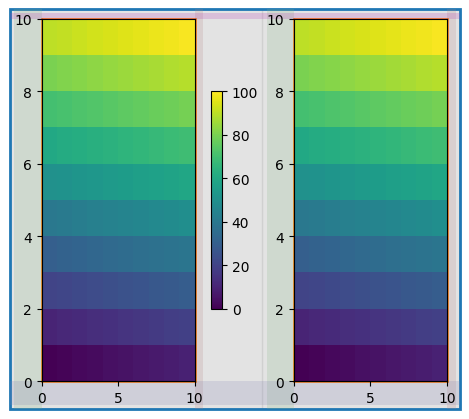

In [32]:
fig, ax = plt.subplots(1, 2, layout="constrained")
im = ax[0].pcolormesh(arr, **pc_kwargs)
fig.colorbar(im, ax=ax[0], shrink=0.6)
im = ax[1].pcolormesh(arr, **pc_kwargs)
plot_children(fig)

### Colorbar associated with a Gridspec

If a colorbar belongs to more than one cell of the grid, then
it makes a larger margin for each:



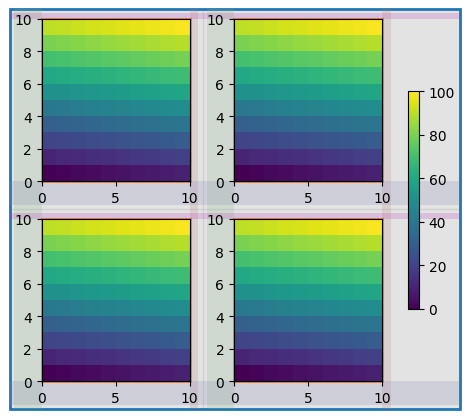

In [33]:
fig, axs = plt.subplots(2, 2, layout="constrained")
for ax in axs.flat:
    im = ax.pcolormesh(arr, **pc_kwargs)
fig.colorbar(im, ax=axs, shrink=0.6)
plot_children(fig)

### Uneven sized Axes

There are two ways to make Axes have an uneven size in a
Gridspec layout, either by specifying them to cross Gridspecs rows
or columns, or by specifying width and height ratios.

The first method is used here.  Note that the middle ``top`` and
``bottom`` margins are not affected by the left-hand column.  This
is a conscious decision of the algorithm, and leads to the case where
the two right-hand Axes have the same height, but it is not 1/2 the height
of the left-hand Axes.  This is consistent with how ``gridspec`` works
without *constrained layout*.



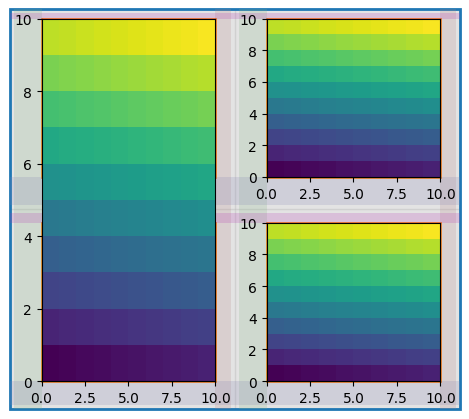

In [34]:
fig = plt.figure(layout="constrained")
gs = gridspec.GridSpec(2, 2, figure=fig)
ax = fig.add_subplot(gs[:, 0])
im = ax.pcolormesh(arr, **pc_kwargs)
ax = fig.add_subplot(gs[0, 1])
im = ax.pcolormesh(arr, **pc_kwargs)
ax = fig.add_subplot(gs[1, 1])
im = ax.pcolormesh(arr, **pc_kwargs)
plot_children(fig)

One case that requires finessing is if margins do not have any artists
constraining their width. In the case below, the right margin for column 0
and the left margin for column 3 have no margin artists to set their width,
so we take the maximum width of the margin widths that do have artists.
This makes all the Axes have the same size:



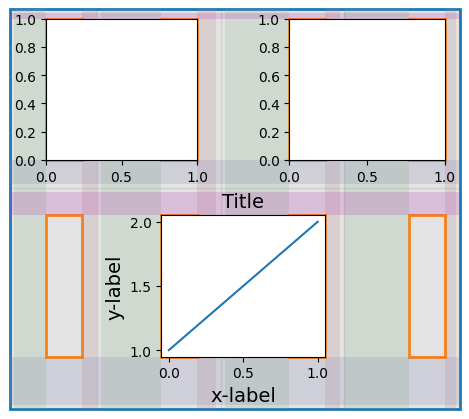

In [35]:
fig = plt.figure(layout="constrained")
gs = fig.add_gridspec(2, 4)
ax00 = fig.add_subplot(gs[0, 0:2])
ax01 = fig.add_subplot(gs[0, 2:])
ax10 = fig.add_subplot(gs[1, 1:3])
example_plot(ax10, fontsize=14)
plot_children(fig)
plt.show()